In [175]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import numpy as np    
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import datetime as dt
from tqdm import tqdm
import pandas as pd

In [2]:
ssts = xr.open_dataset('/mnt/c/Users/Bpara/Downloads/sst.mnmean.nc')
ssts = ssts.sel(time=ssts.time.dt.year>1949)
ssts = ssts.sel(time=ssts.time.dt.year<2022)

anomaly_months = [dt.datetime(1954, 9, 1), dt.datetime(1964, 1, 1), dt.datetime(1977, 2, 1), dt.datetime(1988, 8, 1), dt.datetime(2000, 2, 1), 
                dt.datetime(2006, 9, 1), dt.datetime(2012, 8, 1)]

#import sea surface temps from post 1950 via ersst
ssts

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 864, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-11-04

In [3]:
def month_avg(ssts, month):
    return ssts.sel(time=ssts.time.dt.month==month).mean(dim='time')

In [4]:
%%time
#it doesn't like it if I use a list comprehension for this, so good ole for loop & append is gonna have to do it
months_avg = None
ssts.load()
for year in tqdm(range(1950, 2022)):
    for month in range(1, 13):
        temp = ssts.sel(time=ssts.time.dt.month==month).mean(dim='time')
        temp = temp.expand_dims({'time': 1})
        temp = temp.assign_coords({'time': ('time', [dt.datetime(year, month, 1)])})
        if months_avg is not None:
            months_avg = xr.merge([months_avg, temp])
        else:
            months_avg = temp

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [01:05<00:00,  1.10it/s]

CPU times: user 47.9 s, sys: 6.69 s, total: 54.6 s
Wall time: 1min 5s


In [5]:
months_avg

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 864, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

In [6]:
def month_anomaly_plot(ssts, year_month):
    
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
    im = ax.pcolor(ssts['lon']+180, ssts['lat'], ssts['sst'].sel(time=year_month)-month_avg(ssts, year_month.month)['sst'], 
                   alpha=0.75, cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(im)
    ax.set_title(f'''Sea surface temperature anomaly for {months[year_month.month]}, {year_month.year} \n
compared to 1950-2022 {months[year_month.month]} Average''')

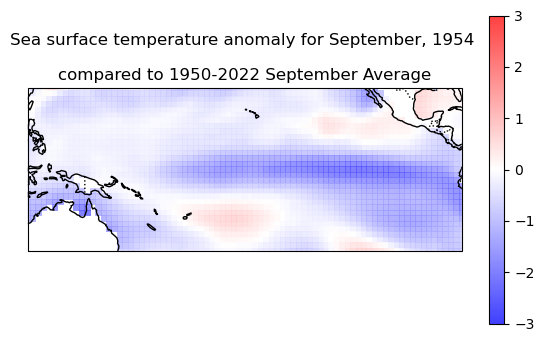

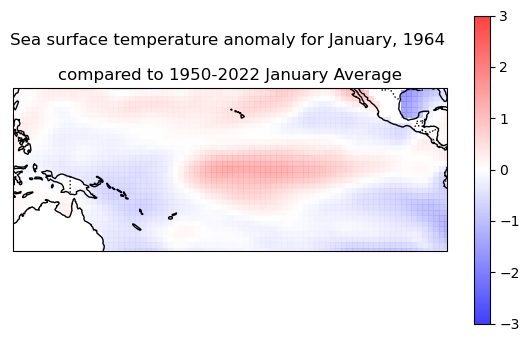

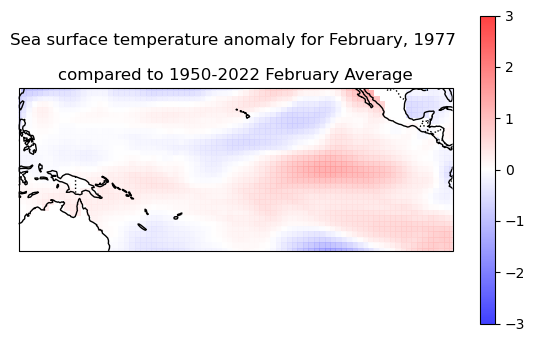

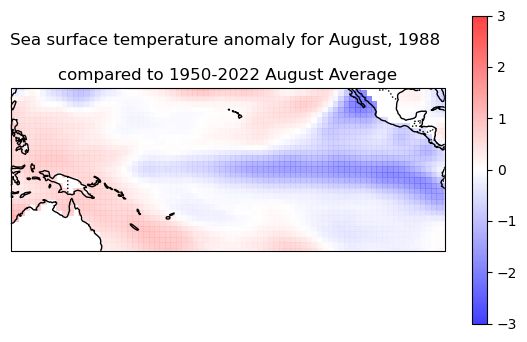

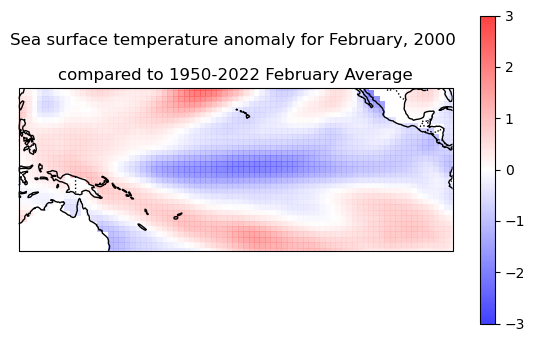

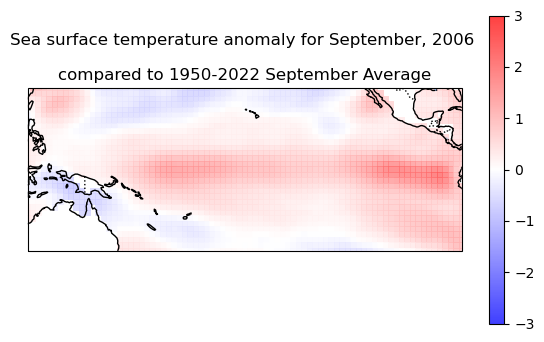

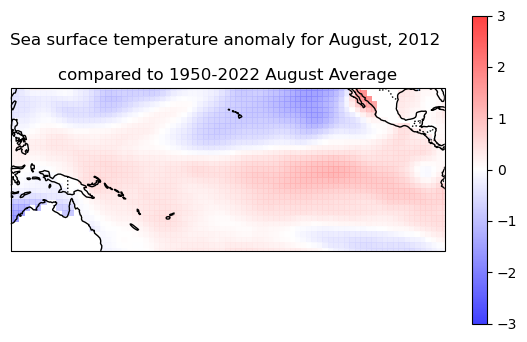

In [7]:
for anomaly in anomaly_months:
    month_anomaly_plot(ssts, anomaly)

In [21]:
mean_anomaly = ssts.sel(time=anomaly_months) - months_avg.sel(time=anomaly_months)

Text(0.5, 1.0, 'Average of all 7 low flow event Sea surface temperature \nanomaly')

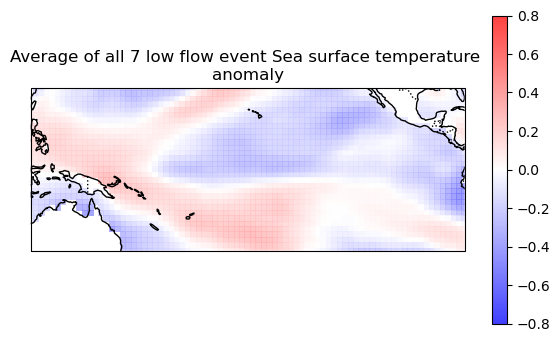

In [9]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(ssts['lon']+180, ssts['lat'], mean_anomaly.mean(dim='time')['sst'], alpha=0.75, cmap='bwr', vmin=-0.8, vmax=0.8)
plt.colorbar(im)
ax.set_title('Average of all 7 low flow event Sea surface temperature \nanomaly')

Text(0.5, 1.0, '33rd quantile of all 7 low flow event \n Sea surface temperature anomaly')

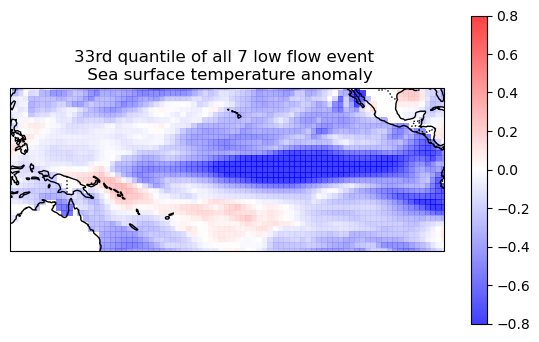

In [10]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(ssts['lon']+180, ssts['lat'], mean_anomaly.quantile(0.33, dim='time')['sst'], alpha=0.75, cmap='bwr', vmin=-0.8, vmax=0.8)
plt.colorbar(im)
ax.set_title('33rd quantile of all 7 low flow event \n Sea surface temperature anomaly')

Text(0.5, 1.0, '66thd quantile of all 7 low flow event \n Sea surface temperature anomaly')

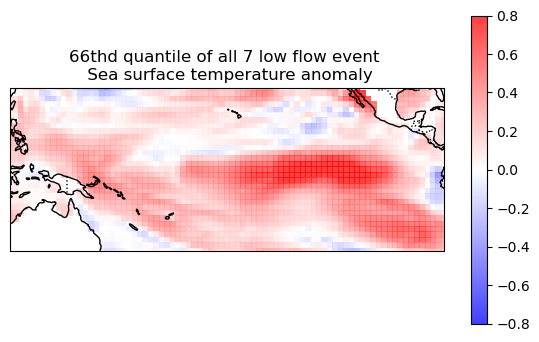

In [11]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(ssts['lon']+180, ssts['lat'], mean_anomaly.quantile(0.66, dim='time')['sst'], alpha=0.75, cmap='bwr', vmin=-0.8, vmax=0.8)
plt.colorbar(im)
ax.set_title('66thd quantile of all 7 low flow event \n Sea surface temperature anomaly')

Theory: Each monthly SST anomaly pattern is being drawn from some theoretical distrubition of 2D SST anomaly patterns according to some probability distribution. We have N=72 draws for each month for 852 draws total, so if I draw M=50,000 864-size samples with replacement from each month and calculate the mean and standard deviation of the distribution of SST anomalies, I can find a bootstrapped estimate for the mean monthly anomaly and the standard deviation of said mean monthly anomaly. This assumes the monthly anomaly is being pulled from the same distribution each month however, which might be a point to revisit

In [12]:
def generate_months(num_months, year_min, year_max, month_min, month_max, random_seed=42):
    rng = np.random.default_rng(seed=random_seed)
    years = rng.integers(low=year_min, high=year_max, size=num_months)
    months = rng.integers(low=month_min, high=month_max, size=num_months)
    return [dt.datetime(year, month, 1) for year, month in zip(years, months)]

In [13]:
def bootstrap_ssts(ssts, months_avg, resample_size, num_resamples, lat_min=30, lon_min=120, lat_max=-30, lon_max=280, starting_random_seed=42, 
                   year_min=1950, year_max=2021, month_min=1, month_max=12,):
    
    bootstrap_sample_mean = None
    bootstrap_sample_std = None
    
    for m in tqdm(range(num_resamples)):
        months = generate_months(resample_size, year_min, year_max, month_min, month_max, random_seed=starting_random_seed+m)
        resample_pull = (ssts.sel(time=months, lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)) - 
                         months_avg.sel(time=months, lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)))
        
        resample_mean = resample_pull.mean(dim='time')
        resample_mean = resample_mean.expand_dims({'pull_num': 1})
        resample_mean = resample_mean.assign_coords({'pull_num': ('pull_num', [m])})
        if bootstrap_sample_mean is not None:
            bootstrap_sample_mean = xr.merge([bootstrap_sample_mean, resample_mean])
        else:
            bootstrap_sample_mean = resample_mean
            
        resample_std = resample_pull.std(dim='time')
        resample_std = resample_std.expand_dims({'pull_num': 1})
        resample_std = resample_std.assign_coords({'pull_num': ('pull_num', [m])})
        #Doing this instead of merging at the end because with large num_resamples the kernel dies. The trade-off is it slows as m increases
        if bootstrap_sample_std is not None:
            bootstrap_sample_std = xr.merge([bootstrap_sample_std, resample_std])
        else:
            bootstrap_sample_std = resample_std
            
    return bootstrap_sample_mean, bootstrap_sample_std
        

In [14]:
mean, std = bootstrap_ssts(ssts, months_avg, 7, 1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.62it/s]


In [15]:
mean.mean(dim='pull_num')

<xarray.Dataset>
Dimensions:    (lat: 31, lon: 81, nbnds: 2)
Coordinates:
  * lat        (lat) float32 30.0 28.0 26.0 24.0 ... -24.0 -26.0 -28.0 -30.0
  * lon        (lon) float32 120.0 122.0 124.0 126.0 ... 274.0 276.0 278.0 280.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (nbnds) float64 0.0 0.0
    sst        (lat, lon) float32 nan -0.01318 -0.01427 ... 0.006345 0.007821

NameError: name 'sst_std' is not defined

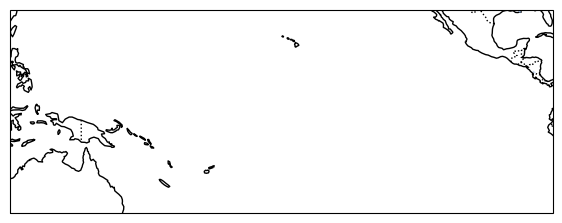

In [16]:
ssts_mean = mean.mean(dim='pull_num')['sst']

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(sst_std['lon']+180, sst_std['lat'], ssts_mean, alpha=0.75, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(im)
ax.set_title('Mean of SST anomaly with n=7 pulled 1000 times')

In [ ]:
ssts_10 = mean.quantile(0.1, dim='pull_num')['sst']

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(sst_std['lon']+180, sst_std['lat'], ssts_10, alpha=0.75, cmap='bwr', vmin=-0.5, vmax=0.5)
plt.colorbar(im)
ax.set_title('10% quantile of SST anomaly with n=7 pulled 1000 times')

In [ ]:
ssts_90 = mean.quantile(0.9, dim='pull_num')['sst']

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(sst_std['lon']+180, sst_std['lat'], ssts_90, alpha=0.75, cmap='bwr', vmin=-0.5, vmax=0.5)
plt.colorbar(im)
ax.set_title('90% quantile of SST anomaly with n=7 pulled 1000 times')

In [ ]:
def month_anomaly_zscore_plot(ssts, ssts_std, year_month, lat_min=30, lon_min=120, lat_max=-30, lon_max=280):
    
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    
    ssts_trim = ssts.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    ssts_std_trim = ssts_std.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
    im = ax.pcolor(ssts_trim['lon']+180, ssts_trim['lat'], 
                   (ssts_trim['sst'].sel(time=year_month)-month_avg(ssts_trim, year_month.month)['sst'])/ssts_std_trim, 
                   alpha=0.25, cmap='bwr', vmin=-3, vmax=3)
    cs = ax.contour(ssts_trim['lon']+180, ssts_trim['lat'], 
                   (ssts_trim['sst'].sel(time=year_month)-month_avg(ssts_trim, year_month.month)['sst'])/ssts_std_trim,
                    cmap='bwr', levels = np.linspace(-3, 3, 13))
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('Z-score', rotation=270)
    ax.clabel(cs, cs.levels, inline=True, fontsize=6)
    ax.set_title(f'''Sea surface temperature anomaly for {months[year_month.month]}, {year_month.year} \n
compared to 1950-2021 {months[year_month.month]} Average''')

In [ ]:
for anomaly in anomaly_months:
    _, ssts_std =bootstrap_ssts(ssts, months_avg, 71, 1000, month_min=anomaly.month, month_max=anomaly.month+1)
    month_anomaly_zscore_plot(ssts, ssts_std.mean(dim='pull_num')['sst'], anomaly)


If the anomaly of each event is independent, which I think is a reasonable enough assumption given that the closest time difference between the 2 is ~6 years, and the anomaly is normally distributed, which seems a reasonable enough assumption, I can model the composite average there as a random variable with mean zero (since all the averages have mean zero) a standard deviation equal to the square root of the sum of each month's std squared ie sqrt(std1^2+std2^2...) and that will give me the z-score of that

In [18]:
mean_anomaly = 0
std_anomaly = 0
for anomaly in anomaly_months:
#    mean_anomaly+=(ssts['sst'].sel(time=anomaly)-month_avg(ssts, anomaly.month)['sst'])/len(anomaly_months)
    _, ssts_std =bootstrap_ssts(ssts, months_avg, 71, 1000, month_min=anomaly.month, month_max=anomaly.month+1)
    std_anomaly += ssts_std.mean(dim='pull_num')['sst']**2/len(anomaly_months)**2
std_anomaly = np.sqrt(std_anomaly)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.67it/s]


In [74]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
vals = np.zeros((3, 4))
white = ListedColormap(vals)

In [ ]:
lat_min=30
lon_min=120
lat_max=-30
lon_max=280
ssts_10 = mean.quantile(0.1, dim='pull_num')['sst']
ssts_90 = mean.quantile(0.9, dim='pull_num')['sst']
ssts_33 = mean.quantile(0.33, dim='pull_num')['sst']
ssts_66 = mean.quantile(0.66, dim='pull_num')['sst']


mean_anomaly_trim =  mean_anomaly.mean(dim='time')['sst'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
mean_anomaly_trim1 = (ssts_33 > mean_anomaly.mean(dim='time')['sst']).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
mean_anomaly_trim2 = (ssts_66 < mean_anomaly.mean(dim='time')['sst']).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
mean_anomaly_trim3 = (ssts_10 > mean_anomaly.mean(dim='time')['sst']).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
mean_anomaly_trim4 = (ssts_90 < mean_anomaly.mean(dim='time')['sst']).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

sigma1 = (mean_anomaly_trim1 | mean_anomaly_trim2)
sigma2 = (mean_anomaly_trim3 | mean_anomaly_trim4)

open_list_lat = []
open_list_lon = []
closed_list_lat = []
closed_list_lon = []
for (lat_i, lat) in enumerate(mean_anomaly_trim['lat']):
    for (lon_i, lon) in enumerate(mean_anomaly_trim['lon']):
        if sigma2[lat_i, lon_i]:
            closed_list_lat.append(lat)
            closed_list_lon.append(lon)
            continue
        if sigma1[lat_i, lon_i]:
            open_list_lat.append(lat)
            open_list_lon.append(lon)
            
open_list_lat = np.asarray(open_list_lat)
open_list_lon = np.asarray(open_list_lon)
closed_list_lat = np.asarray(closed_list_lat)
closed_list_lon = np.asarray(closed_list_lon)


fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))

ax.set_xticks([120, 140, 160, 180, 200, 220, 240, 260, 280], crs=ccrs.PlateCarree())
ax.set_yticks([-30, -20, -10, 0, 10, 20, 30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


im = ax.pcolor(mean_anomaly_trim0['lon']+180, mean_anomaly_trim0['lat'], mean_anomaly_trim0, cmap='bwr', vmin = -0.5, vmax = 0.5)
ax.scatter(open_list_lon+180, open_list_lat, 10, transform=ccrs.PlateCarree(central_longitude=180), facecolors='none', edgecolors='black')
ax.scatter(closed_list_lon+180, closed_list_lat, 10, transform=ccrs.PlateCarree(central_longitude=180), facecolors='black', edgecolors='black')
ax.grid(alpha = 0.75)

cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Temperature anomaly (degrees Celsius)', rotation=270)


ax.set_title(f'''Average Sea surface temperature anomaly \ncompared to 1950-2021 Bootstrapped Mean Quantiles''')

plt.savefig('Average low flow SST anomaly plot')